# Testing the `MultivariateCoupledNormal` class and entropy functions with $\kappa = 0$

Use `!pip install -i https://test.pypi.org/simple/ nsc-test` to install the latest version of `nsc-test`.

In [1]:
#!pip install -i https://test.pypi.org/simple/ nsc

# Setting up

In [2]:
import nsc
import numpy as np
from scipy.stats import multivariate_normal
from nsc.distributions import MultivariateCoupledNormal
from nsc.math.entropy import importance_sampling_integrator
from nsc.math.entropy_norm import coupled_normal_entropy, biased_coupled_probability_norm, coupled_probability_norm, coupled_cross_entropy_norm, coupled_entropy_norm, coupled_kl_divergence_norm
import matplotlib.pyplot as plt

Importing NSC lib v0.0.4.12.


In [3]:
# Set the locs.
loc = np.array([[0, 0,],
                [1, -1],
                [-3, 5]])
# Set the scales.
scale = np.array([[1, 1],
                  [1.2, 0.8],
                  [1.5, 1.6]])

# Find the number of batches.
n_batches = loc.shape[0]

# Set the kappa.
kappa = 0.0

# Initialize a MultivariateCoupledNormal object.
mvn = MultivariateCoupledNormal(loc=loc, scale=scale, kappa=kappa)

In [4]:
def kl_divergence_MVN(mu_1, mu_2, Sigma_1, Sigma_2):
    """
    This function calculates the KL divergence between 2 multivariate normal distributions.
    
    Inputs
    -------
    mu_1 : numpy ndarray
        A 1-D array representing the mean vector of the first distribution.
    mu_2 : numpy ndarray
        A 1-D array representing the mean vector of the second distribution.
    Sigma_1 : numpy ndarray
        A 2-D square array representing the covariance matrix of the first distribution.
    Sigma_2 : numpy ndarray
        A 2-D square array representing the covariance matrix of the second distribution.
        
    Returns
    -------
    kl_div : float
        The KL Divergence between distributions 1 and 2.
    """
    
    # Validate input shapes.
    assert ((mu_1.shape == mu_2.shape)
            & (len(mu_1.shape) == 1)), "Mean vectors must have the same shape and be 1-D."
    assert ((Sigma_1.shape[0] == Sigma_1.shape[1])
            & (Sigma_1.shape == Sigma_2.shape)), "Sigma_1 and Sigma_2 must be square matrices with matching shapes."
    assert (mu_1.shape[0] == Sigma_1.shape[0]), "If the mean vectors are n by 1, the covariance matrices must be n by n."
    
    # Calculate the difference between the 2nd mean vector and the first.
    mean_diff = mu_2 - mu_1
    # Find the inverse of Sigma_2.
    Sigma_2_inv = np.linalg.inv(Sigma_2)
    
    # Get the dimensionality of the two distributions based on the first
    # dimension of the mu_1 vector.
    d = mu_1.shape[0]
    
    # Calculate the KL divergence.
    kl_div = np.log(np.linalg.det(Sigma_2)) - np.log(np.linalg.det(Sigma_1))
    kl_div -= d
    kl_div += np.trace(np.matmul(Sigma_2_inv, Sigma_1))
    kl_div += np.matmul(np.matmul(mean_diff.T, Sigma_2_inv), mean_diff)
    kl_div *= 0.5
    
    # Return the KL divergence.
    return kl_div

# Testing `sample_n`

In [5]:
# Set the number of samples per batched distribution.
n = 10000
# Sample n observations from each batched distribution.
samples = mvn.sample_n(n)

print(f"Expected dimensions of samples: {loc.shape[0], n, loc.shape[1]}")
print(f"Actual dimensions of samples: {samples.shape}")

Expected dimensions of samples: (3, 10000, 2)
Actual dimensions of samples: (3, 10000, 2)


In [6]:
for i in range(n_batches):
    print(f"Mean of distribution 1: {tuple(loc[i])}")
    print(f"Mean of samples from distribution 1: {tuple(samples[i].mean(axis=0))}")
    print(f"Std. Dev. of distribution 1: {tuple(scale[i])}")
    print(f"Std. Dev. of samples from distribution 1: {tuple(samples[i].std(axis=0))}")
    print("\n")

Mean of distribution 1: (0, 0)
Mean of samples from distribution 1: (-0.00855663173519223, -0.022130173484748855)
Std. Dev. of distribution 1: (1.0, 1.0)
Std. Dev. of samples from distribution 1: (0.9940238575195032, 1.010458373784779)


Mean of distribution 1: (1, -1)
Mean of samples from distribution 1: (1.0094194728572368, -1.0036655056232722)
Std. Dev. of distribution 1: (1.2, 0.8)
Std. Dev. of samples from distribution 1: (1.1987992604354392, 0.7878092407932633)


Mean of distribution 1: (-3, 5)
Mean of samples from distribution 1: (-3.015849047591126, 4.978023812743072)
Std. Dev. of distribution 1: (1.5, 1.6)
Std. Dev. of samples from distribution 1: (1.4933632658789022, 1.6064727042875186)




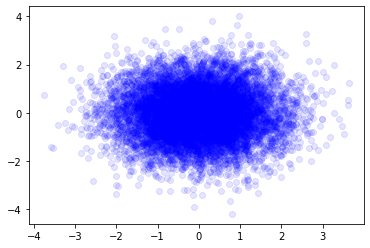

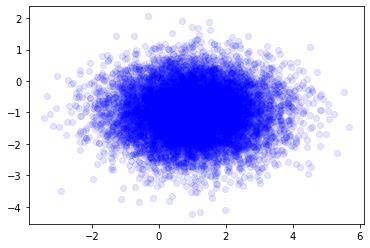

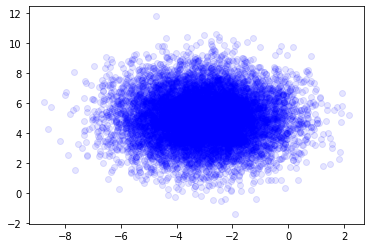

In [7]:
for i in range(samples.shape[0]):
    x, y = samples[i, :,0], samples[i, :,1]
    plt.scatter(x, y,
                color="blue", alpha=0.1)
    plt.show()

# Testing `prob` with batches (multiple distributions)

In [8]:
mvn_probs = mvn.prob(samples)

# Loop through the 
for i in range(n_batches):
    # Get the i-th distributions sample densities and reshape them to be 1-D.
    dist_1_probs = mvn_probs[i].reshape(-1,)
    # Initialize a scipy multivariate_normal object.
    mvn_scipy_1 = multivariate_normal(loc[i], scale[i]**2)
    # Get the probability densities from scipy object.
    scipy_probs_1 = mvn_scipy_1.pdf(samples[i])
    
    print(f"The densities from the Coupled MVN and SciPy MVN are close: {np.allclose(dist_1_probs, scipy_probs_1)}")
    print("\n")

The densities from the Coupled MVN and SciPy MVN are close: True


The densities from the Coupled MVN and SciPy MVN are close: True


The densities from the Coupled MVN and SciPy MVN are close: True




# `importance_sampling_integrator`

In [9]:
importance_sampling_integrator(mvn.prob, mvn.prob, mvn.sample_n, n=10000, seed=1)

C:\Users\jkcle\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[[1.]],

       [[1.]],

       [[1.]]])

# `coupled_normal_entropy`

In [10]:
#coupled_normal_entropy(mvn._sigma, kappa=0.0)

C:\Users\jkcle\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
#coupled_normal_entropy(mvn._sigma, kappa=0.003)

In [12]:
#mvn._sigma

In [13]:
#0.5 * np.log((2*np.pi*np.exp(1)) ** mvn.loc[0].shape[0] * np.linalg.det(mvn._sigma[0]))

# `biased_coupled_probability_norm`

In [14]:
new_mvn = biased_coupled_probability_norm(mvn, kappa=0.1, alpha=2)

print(new_mvn.loc)
print(new_mvn._sigma)
print(new_mvn.kappa)

[[ 0  0]
 [ 1 -1]
 [-3  5]]
[[[0.85714286 0.        ]
  [0.         0.85714286]]

 [[1.23428571 0.        ]
  [0.         0.54857143]]

 [[1.92857143 0.        ]
  [0.         2.19428571]]]
0.0


In [15]:
new_mvn_samples = new_mvn.sample_n(100)

# `coupled_probability_norm`

In [16]:
new_mvn_pdf = coupled_probability_norm(mvn, kappa=0.1, alpha=2.0)

np.all(new_mvn_pdf(new_mvn_samples) == new_mvn.prob(new_mvn_samples))

True

# `coupled_cross_entropy_norm`

In [17]:
coupled_cross_entropy_norm(
    mvn,
    new_mvn,
    kappa=0.0, 
    alpha=2.0, 
    root=False,
    n=10000,
    seed=1
)

C:\Users\jkcle\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[[2.85047335]],

       [[2.80824288]],

       [[3.73685395]]])

# `coupled_entropy_norm`

In [18]:
coupled_entropy_norm(
    mvn,
    kappa=0.0, 
    alpha=2.0, 
    root=False,
    n=10000,
    seed=1
)

C:\Users\jkcle\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[[2.83794589]],

       [[2.79591663]],

       [[3.72276765]]])

In [19]:
true_entropies = [
    0.5 * np.log((2*np.pi*np.exp(1)) ** mvn.loc[i].shape[0] * np.linalg.det(mvn._sigma[i])) for i in range(mvn._batch_shape[0])
]
true_entropies = np.array(true_entropies)
true_entropies.reshape(mvn._batch_shape[0], 1, 1)

C:\Users\jkcle\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[[2.83787707]],

       [[2.79705507]],

       [[3.7133458 ]]])

# `coupled_kl_divergence_norm`

In [39]:
# Set the locs.
loc_alt = np.array([[1, 2,],
                [-0.5, 0.75],
                [-2.6, .1]])
# Set the scales.
scale_alt = np.array([[1.2, 0.9],
                  [1.7, 2.5],
                  [0.99, 1.25]])

# Find the number of batches.
n_batches = loc.shape[0]

# Set the kappa.
kappa = 0.0

# Initialize a MultivariateCoupledNormal object.
new_mvn = MultivariateCoupledNormal(loc=loc, scale=scale_alt, kappa=kappa)

In [43]:
coupled_kl_divergence_norm(
    mvn, 
    new_mvn, 
    kappa=0.0, 
    alpha=2.0, 
    root=False,
    n=100000,
    seed=1
)

array([[[0.04002242]],

       [[0.78629383]],

       [[0.30305328]]])

In [42]:
locs_1 = mvn.loc
scales_1 = mvn.scale**2

locs_2 = new_mvn.loc
scales_2 = new_mvn.scale**2

for i in range(locs_1.shape[0]):
    print(kl_divergence_MVN(locs_1[i], locs_2[i], scales_1[i], scales_2[i]))

0.041467213975634465
0.7880759255534662
0.30466653503977437


In [23]:
coupled_kl_divergence_norm(
    mvn, 
    mvn, 
    kappa=0.0, 
    alpha=2.0, 
    root=False,
    n=10000,
    seed=1
)

array([[[0.]],

       [[0.]],

       [[0.]]])

In [24]:
coupled_kl_divergence_norm(
    new_mvn, 
    new_mvn, 
    kappa=0.0, 
    alpha=2.0, 
    root=False,
    n=10000,
    seed=1
)

C:\Users\jkcle\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[[0.]],

       [[0.]],

       [[0.]]])